# Module: latticevectors

This module contains functions related to determining the lattice vectors, and making use of them in subsequent calculations.  This includes obtaining an initial guess at the lattice vectors, calculating refined fits to the lattice vectors at each diffraction pattern, strain mapping, and orientation mapping.

## Submodule: fit

This notebook demos fitting lattice vectors to measured diffraction spots at each scan position, starting from an already known initial guess at the lattice vectors.  We proceed as follows:

* Index each Bragg direction, using the initial u,v guess and the Bragg vector map
* For one scan position, fit the lattice vectors
* For each scan position, fit the lattice vectors

The relevant mathematical formalism can be found at the end of this notebook.

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from numpy.linalg import lstsq
from scipy.ndimage.morphology import binary_closing

from py4DSTEM.file.datastructure import RealSlice, PointList
from py4DSTEM.file.io import FileBrowser, read, append

from py4DSTEM.process.latticevectors import index_bragg_directions, fit_lattice_vectors, fit_lattice_vectors_all_DPs
from py4DSTEM.process.utils import get_maxima_2D

In [25]:
# Examine file contents

fp = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
browser = FileBrowser(fp)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    datacube                            DataCube            
   1    braggvectormap_shiftcorrected_ellipsecorrectedDiffractionSlice    
   2    braggvectormap_uncorrected          DiffractionSlice    
   3    probe                               DiffractionSlice    
   4    diffraction_shifts                  RealSlice           
   5    strain_map                          RealSlice           
   6    uv_map                              RealSlice           
   7    lattice_vectors                     PointList           
   8    braggpeaks                          PointListArray      
   9    braggpeaks_shifted_ellipticalcorrectedPointListArray      


In [26]:
# Load data

dc = browser.get_dataobject('datacube')
Bragg_peaks = browser.get_dataobject('braggpeaks_shifted_ellipticalcorrected')
lattice_vectors = browser.get_dataobject('lattice_vectors')
braggvectormap = browser.get_dataobject('braggvectormap_shiftcorrected_ellipsecorrected').data
browser.close()

### Index Bragg directions

In [27]:
# Get beta, the lattice vector matrix
# Note that for the initial pass

x0,y0 = np.unravel_index(np.argmax(gaussian_filter(braggvectormap,2)),braggvectormap.shape)

ux = lattice_vectors.data['qx'][0]
uy = lattice_vectors.data['qy'][0]
vx = lattice_vectors.data['qx'][1]
vy = lattice_vectors.data['qy'][1]

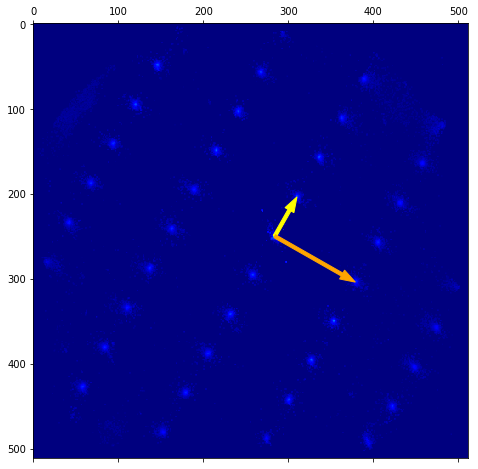

In [28]:
# Show Bragg vector map and lattice vectors

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(braggvectormap**0.25,cmap='jet')
ax.arrow(y0,x0,uy,ux, color='yellow',width=4,length_includes_head=True)
ax.arrow(y0,x0,vy,vx, color='orange',width=4,length_includes_head=True)
plt.show()

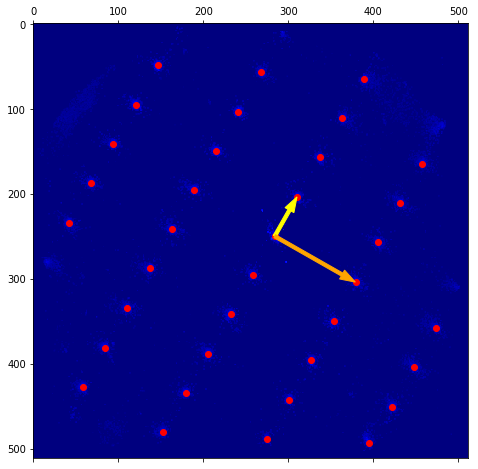

In [29]:
# Find Bragg vector map peak positions

sigma = 2
minSpacing = 40
minRelativeIntensity = 0.05
relativeToPeak = 1
maxNumPeaks = 40

power = 0.25

maxima_x,maxima_y,_ = get_maxima_2D(braggvectormap, sigma=sigma, minSpacing=minSpacing, minRelativeIntensity=minRelativeIntensity,
                                    relativeToPeak=relativeToPeak, maxNumPeaks=maxNumPeaks)

# Show
fig,ax=plt.subplots(figsize=(8,8))
ax.matshow(braggvectormap**power,cmap='jet')
ax.scatter(maxima_y,maxima_x,color='r')
ax.arrow(y0,x0,uy,ux, color='yellow',width=4,length_includes_head=True)
ax.arrow(y0,x0,vy,vx, color='orange',width=4,length_includes_head=True)
plt.show()

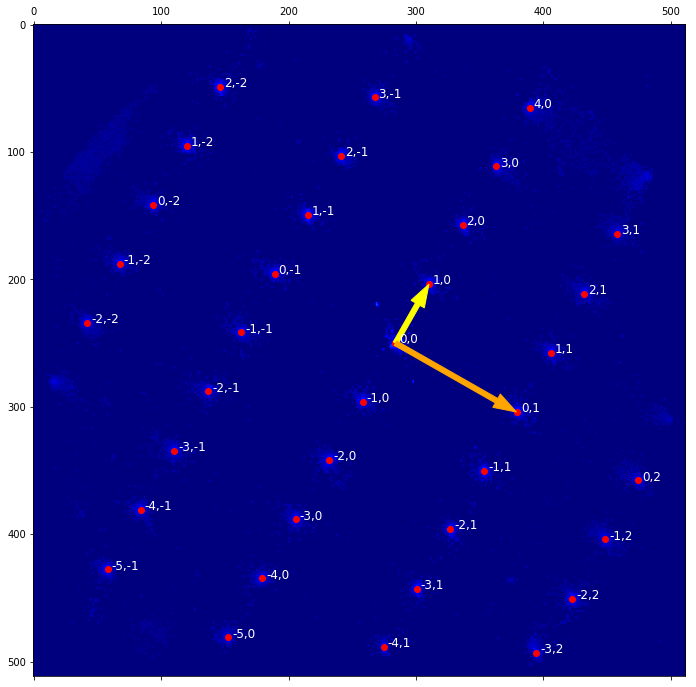

In [30]:
# Calculate indices

textoffset=3

# Get indices
h,k,bragg_directions = index_bragg_directions(x0,y0,ux,uy,vx,vy,maxima_x,maxima_y)

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(braggvectormap**.25,cmap='jet')
ax.scatter(bragg_directions.data['qy'],bragg_directions.data['qx'],color='r')
ax.arrow(y0,x0,uy,ux, color='yellow',width=4,length_includes_head=True)
ax.arrow(y0,x0,vy,vx, color='orange',width=4,length_includes_head=True)
for i in range(bragg_directions.length):
    ax.text(bragg_directions.data['qy'][i]+textoffset,bragg_directions.data['qx'][i],
            '{},{}'.format(bragg_directions.data['h'][i],bragg_directions.data['k'][i]),
            color='w',size=12)
plt.show()

### Fit lattice vectors, one diffraction pattern

In [36]:
# Fit lattice vectors, one diffraction pattern

rx,ry = 25,25
maxPeakSpacing = 20
bragg_peaks = Bragg_peaks.get_pointlist(rx,ry)

ux,uy,vx,vy,error = fit_lattice_vectors(bragg_peaks, bragg_directions, x0, y0, maxPeakSpacing)

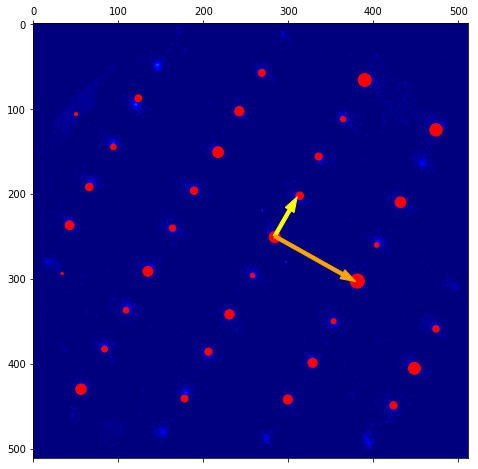

In [38]:
# Show

size_scale_factor = 200

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(braggvectormap**.25,cmap='jet')
if size_scale_factor == 0:
    ax.scatter(bragg_peaks.data['qy'],bragg_peaks.data['qx'],color='r')
else:
    ax.scatter(bragg_peaks.data['qy'],bragg_peaks.data['qx'],color='r',s=size_scale_factor*bragg_peaks.data['intensity']/np.max(bragg_peaks.data['intensity']))
ax.arrow(y0,x0,uy,ux, color='yellow',width=4,length_includes_head=True)
ax.arrow(y0,x0,vy,vx, color='orange',width=4,length_includes_head=True)
plt.show()

### Fit lattice vectors, all DPs

In [40]:
# Fit lattice vectors, all diffraction patterns

maxPeakSpacing = 20
minNumPeaks = 6
x0,y0 = np.unravel_index(np.argmax(braggvectormap),braggvectormap.shape)

uv_map = fit_lattice_vectors_all_DPs(Bragg_peaks, bragg_directions, x0, y0, maxPeakSpacing, minNumPeaks)

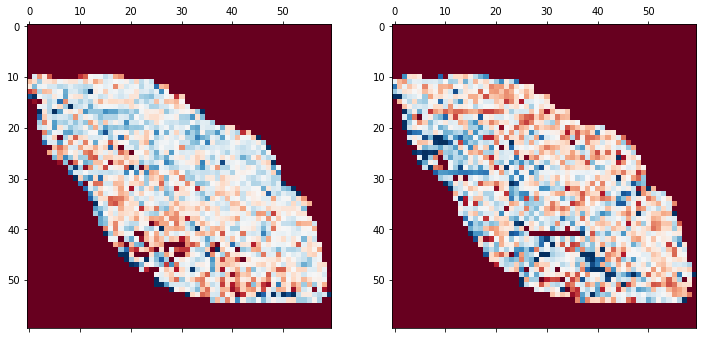

In [41]:
# Show lattice vector lengths

n_stds = 2

u_lengths = np.sqrt(uv_map.slices['ux']**2 + uv_map.slices['uy']**2)
v_lengths = np.sqrt(uv_map.slices['vx']**2 + uv_map.slices['vy']**2)
u_length_ave, u_length_std = np.average(u_lengths[uv_map.slices['mask'].astype(bool)]), np.std(u_lengths[uv_map.slices['mask'].astype(bool)])
v_length_ave, v_length_std = np.average(v_lengths[uv_map.slices['mask'].astype(bool)]), np.std(v_lengths[uv_map.slices['mask'].astype(bool)])

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,12))
ax1.matshow(u_lengths, vmin=u_length_ave-n_stds*u_length_std, vmax=u_length_ave+n_stds*u_length_std, cmap="RdBu")
ax2.matshow(v_lengths, vmin=v_length_ave-n_stds*v_length_std, vmax=v_length_ave+n_stds*v_length_std, cmap="RdBu")
plt.show()

### Relevant mathematics

The computations in this notebook begin assuming that we've already measured Bragg peak positions, and an initial guess at the lattice vectors.  Given these, we

1. Index the observed Bragg peak positions, using our initial guess at the lattice vectors.
2. Using the indexed Bragg peak positions, we'll refine our of the lattice vectors for each diffraction pattern.

The approach here is to solve the system of linear equations:

\begin{align}
\mathbf{g}^{hk} = \mathbf{R}_0 + h\mathbf{u} + k\mathbf{v}
\end{align}

where $\mathbf{R}_0$ is the position of the unscattered beam, i.e. the origin of the diffraction plane, $\mathbf{u}$ and $\mathbf{v}$ are the reciprocal lattice vectors, $h$ and $k$ are integers, and $\mathbf{g}^{hk}$ is the measured position of the reciprocal lattice vector at index $(h,k)$.  Expanding in Cartesian coordinates gives

\begin{align*}
g^{hk}_x &= R_{0,x} + hu_x + kv_x  \\
g^{hk}_y &= R_{0,y} + hu_y + kv_y
\end{align*}

We'll use the matrix solver numpy.linalg.lstsq in each step.  For an equation of the form $\alpha = M\beta$, the solver finds $\beta$ given $\alpha$ and $M$; here, for consistency, we'll therefore always use $\alpha$, $\beta$, and $M$ to refer to the matrices passed to and returned by the lstsq function.  This means we'll define these matrices with respect to $\mathbf{g}^{hk}$, $(\mathbf{u},\mathbf{v})$, and $(h,k)$ slightly differently in each step here.

#### Step 1: Index the observed Bragg peaks

For indexing the Bragg peaks, its easiest to write

\begin{equation}
\begin{pmatrix}
         &   g^{hk}_x - R_{0,x}   &            \\
\cdots   &              &   \cdots   \\
         &   g^{hk}_y - R_{0,y}   &
\end{pmatrix}
=
\begin{pmatrix}
u_x   &   v_x   \\
u_y   &   v_y
\end{pmatrix}
\begin{pmatrix}
         &   h   &            \\
\cdots   &       &   \cdots   \\
         &   k   &
\end{pmatrix}
\end{equation}

Comparing to $\alpha = M \beta$, we find that here, $\alpha$ is the $2\times N$ matrix representing the $N$ detected Bragg peaks measured with respect to the unscattered beam position, $M$ is the $2\times2$ matrix containing the reciprocal lattice vectors, and $\beta$ is the $2\times N$ matrix of the Bragg peak indices.  Solving for $\beta$ given $\alpha$ and $M$ therefore finds the indices $h,k$ given the lattice vectors and the measured Bragg directions.

#### Step 2: Calculate the lattice vectors

In this step we'll calculate the lattice vectors at each diffraction pattern.  We'll allow the origin to shift slightly from one diffraction pattern to the next, so we'll need to slightly restructure the matrices.  We also want to solve for $(\mathbf{u},\mathbf{v})$ rather than $(h,k)$ now, so moving the origin $\mathbf{R}_0$ back to the right hand side and taking a transpose, we'll write the expression as

\begin{equation}
\begin{pmatrix}
&\vdots& \\
g^{hk}_x   & &   g^{hk}_y   \\
&\vdots&
\end{pmatrix}
=
\begin{pmatrix}
    &  \vdots  &       \\
1   &     h    &   k   \\
    &  \vdots  &
\end{pmatrix}
\begin{pmatrix}
R_{0,x}   &   R_{0,y}   \\
u_x   &   u_y   \\
v_x   &   v_y
\end{pmatrix}
\end{equation}

Comparing to $\alpha = M\beta$, we find that here, $\alpha$ is the $N\times 2$ matrix representing the $N$ detected Bragg peaks, $M$ is the $N\times 3$ matrix encoding the indexing of the Bragg peaks, and $\beta$ is the $3\times2$ matrix containing the reciprocal lattice vectors and the origin.  Solving for $\beta$ gives us the lattice vectors.